In [1]:
import os
if not 'id_0123456789876543210' in locals():
    for _ in range(2):
        os.chdir(os.path.split(os.getcwd())[0])
    id_0123456789876543210 = None

In [2]:
from src.python.optimize.solution import intBinary, floatBinary, ndSolution, Category, ndCategory
from src.python.optimize.search import SearchSpace, MarkovGeneticSearch
from src.python.training.validation import Foldify, eval_model
from src.python.model import model_v1, model_v1_hparams
import matplotlib.pyplot as plt
import pickle
import math


plt.style.use('ggplot')

def save_object(obj, file):
    with open(file, "wb") as file:
        pickle.dump(obj, file)

def load_object(file):
    with open(file, "rb") as file:
        loaded_object = pickle.load(file)
    return loaded_object

In [3]:
class SearchSpace_model_v1(SearchSpace):
    def __init__(self, input_dim, seed=None) -> None:
        solution = ndSolution(
            input_dim=intBinary(input_dim, input_dim),
            neurons=intBinary(1, 2**9, digits=0),
            # deep <= 1 + log(neurons / 2.0) / log(2)
            deep=intBinary(1, 2**4, digits=0),
            optimizer=ndCategory({'Adam', 'Nadam', 'RMSprop', 'SGD'},
                                 Adam=floatBinary(0, 0.1, digits=4),  # x > 0
                                 Nadam=floatBinary(0, 0.1, digits=4),  # x > 0
                                 RMSprop=ndSolution(floatBinary(0, 0.1, digits=4),  # x > 0
                                                    floatBinary(0, 1, digits=3)),
                                 SGD=ndSolution(floatBinary(0, 0.1, digits=4),  # x > 0
                                                floatBinary(0, 1, digits=3)),
                                 solname='optimizer_param'),
            activation=ndCategory({'ELU', 'LeakyReLU'},
                                  ELU=floatBinary(0, 0.5, digits=4),
                                  LeakyReLU=floatBinary(0, 0.5, digits=4),
                                  solname='activation_alpha'),
            initializer=Category({'uniform', 'normal'}),
            batch_size=intBinary(2**3, 2**8, digits=0),
            epochs=intBinary(2**5, 2**7, digits=0),
            batch_normalization=Category({True, False}),
            regularization=ndCategory({'l1', 'l2', 'None'},
                                      l1=floatBinary(0, 0.1, digits=4),
                                      l2=floatBinary(0, 0.1, digits=4),
                                      solname='regularization_factor'),
            dropout=ndCategory({'true': True, 'false': False},
                               true=floatBinary(0, 0.5, digits=4),
                               solname='dropout_rate'))
        super().__init__(solution, seed)

    def is_feasible(self, x):
        x = self.solution.decode(x, to_dict=True)
        return (x['deep'] <= 1 + math.log(x['neurons'] / 2.0) / math.log(2) and
                x['optimizer_param'][0] > 0 and
                x['optimizer_param'][1] > 0 and
                x['optimizer_param'][2][0] > 0 and
                x['optimizer_param'][3][0] > 0)

In [4]:
data = load_object(
    'data/covid/classification/dataset/graves_train.model-v1.pkl')

foldify = Foldify.Random(len(data['x']),
                         nfolds=6,
                         val_prop=0.2,
                         sorted=True,
                         weight=data['sample'],
                         group=data['label'],
                         seed=555,
                         datasets=(data['x'], data['y']))

session = load_object(
    'data/covid/classification/session/eval.graves.model-v1-sp1.pkl')


def objetive(**hparam):
    return eval_model(model_v1,
                      hparam=model_v1_hparams(**hparam),
                      foldify=foldify,
                      infile=session,
                      # outfile='data/covid/classification/session/eval.graves.model-v1-sp1.pkl',
                      verbose=1)['summary']['val_mae']


search_space = SearchSpace_model_v1(input_dim=10)

In [5]:
search = MarkovGeneticSearch(objetive,
                             search_space,
                             initial=20,
                             itermax=0,
                             seed=555,
                             argstype='kwargs',
                             infile='data/covid/classification/session/search.graves.model-v1-sp1.pkl',
                             #outfile='data/covid/classification/session/search.graves.model-v1-sp1.pkl'
                             )

search.session.iter_history

Session loaded from 'data/covid/classification/session/search.graves.model-v1-sp1.pkl'.


,time,niter,neval,fmin,fmean,fstd,initial_entropy,final_entropy,probability
0,0.000000,0,0,0.078591,0.249536,0.167683,NaN,0.945077,NaN
1,5464.144941,1,20,0.077459,0.140511,0.084123,0.945077,0.915309,0.000772
2,10977.465884,2,40,0.076875,0.095683,0.039018,0.915309,0.875418,0.000636
3,15774.331168,3,60,0.076492,0.084683,0.024202,0.875418,0.827670,0.001141
4,20462.405060,4,80,0.076492,0.077631,0.000703,0.827670,0.760115,0.001188
5,26008.084062,5,100,0.076383,0.077195,0.000635,0.760115,0.722632,0.000948
6,30389.350332,6,120,0.076383,0.077003,0.000450,0.722632,0.678214,0.000623
7,35856.600086,7,140,0.076219,0.076789,0.000334,0.678214,0.626267,0.000693
8,41052.803731,8,160,0.076219,0.076657,0.000203,0.626267,0.620405,0.000596
9,46289.056103,9,180,0.076176,0.076644,0.000289,0.620405,0.583423,0.000778


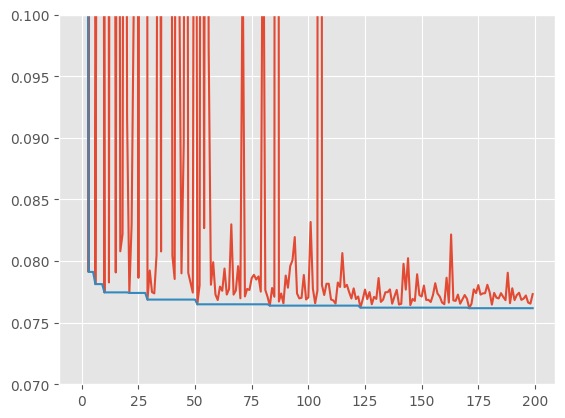

In [6]:
history = search.session.history
iter_history = search.session.iter_history
plt.plot(history.fx)
plt.plot(history.fmin)
plt.ylim((0.07, 0.1))
plt.show()